# Data Analysis on Facebook posts

*This notebook is view-only for now, since MongoDB GCE restricted access for certain IP address, this notebook is built locally with the Mongodb server tunneling to localhost as well. To run this, we can host jupyter server on any VM that is accessible to the Mongo server.*

Data from MongoDB production-mongo-1, we mainly look at post_summary collection in facebook database. We look at all the posts from 2017-05-01 to 2017-05-31 for shared page only. post_summary stop getting updates after 2 weeks so data is static.

---

Questions we want to answer in this analysis:
- How much a facebook page fan worth?
- How much a link click worth?
- breakdown by post type (link click mainly for revenue)
- breakdown by partner/ organic/ influencer traffic
- Fan vs non-fan
- How much on average a page fan worth?
- How many times on average a page fan like our posts (or view content)?
- How much on average a like on our post worth?
- How much on average a share on our post worth? (reach)
- Link clicks vs likes ratio of all posts
- Estimate the probability a fan/non-fan click on a post
- Estimate link click by likes/share/comments (break down by post_type)


- combine with RPS data to estimate a value of a facebook fan (organic)

---
Some key findings so far, based on some generalization and assumptions:
1. We post around 60 posts everyday, 73% of them are link post, 23% are video posts, 4% are photo posts. (compared with Nov 2016, 84% of them are link post, 14% are video posts, 3% are photo posts.)
2. On average, they should see about 90 posts on their news feed average per month (about 147 impressions) and they make about 63 clicks on any of our posts each month.
3. Video post is 20x more engaging than link posts, photo post is about 3x more.
4. Link post: they should see about 53 link posts on their news feed average per month (about 80 impressions) and they make about 4.7 clicks on link posts each month.


In [1]:
# Connecting to Mongodb and import libraries needed
# Edit the startdate and enddate varibale to get data for a different date range
%matplotlib inline
import pymongo
import json
from pprint import pprint
from pymongo import MongoClient
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib
from scipy import stats
from bson.code import Code
matplotlib.style.use('ggplot')
pd.set_option('display.float_format', lambda x: '%.3f' % x)

client = MongoClient()
client = MongoClient('mongodb://localhost:27017') #tunnelling to localhost

#what databases are available
#pprint(client.database_names())
# facebook database
db = client.facebook
#what collections are available
#pprint(db.collection_names())
collection = db.post_summary

startdate = '2017-05-01'
enddate = '2017-05-31'

## Overview

Up to 2017-06-08, there are 384499 posts in the collection, 29841 of them are posted on Shared Facebook page, in 2017 May, there are 1850 posts.

In [2]:
pprint(collection.count())
pprint(collection.find({'page_name':'Shared'}).count())
pprint(collection.find({'page_name':'Shared','date':{'$gte': startdate,'$lte': enddate}}).count())

389444
30531
1850


Let's have a look on one record, fields that are potentially useful in this analysis:
- page_name (filter by 'Shared')
- date (filter from 2017-05-01 to 2017-05-31')
- post_id 
- post_type (link, photo, video)
- brand_domain (breakdown by brand)
- page_likes (Shared page fan on the day the post created)
- post_likes (post_likes_on_post, post_likes_on_shares)
- post_comments (post_comments_on_post, post_comments_on_shares)
- post_shares
- post_reactions_total (like, love, wow, haha, sad, angry, thankful)
- post_impressions_unique (The number of people who saw your Page post)
- post_impressions (The number of impressions for your Page post)
- post_impressions_fan (The number of impressions for your Page post by people who have liked your Page)
- post_impressions_fan_unique (The number of people who have like your Page who saw your Page post)
- post_link_clicks (The number of clicks on the link)
- post_link_clicks_unique (The number of people who have click on the link, this is our conversion)
- post_engaged_users (The number of people who clicked anywhere in your posts)
- timestamp (post created timestamp)
- updated_at (post last update timestamp, usually it is 2 week after the created timestamp)
- reached_size_ratio (post_impressions_unique / page_likes)
- reached_size_ratio_fan (post_impressions_fan_unique / page_likes)
- click_size_ratio (post_link_clicks / page_size)
- clicks_to_impressions (post_clicks / post_impressions_unique)
- link_clicks_to_impressions (post_link_clicks / post_impressions_unique)



In [3]:
collection.find_one({'page_name':'Shared','date':{'$gte': startdate,'$lte': enddate}});

 **We post around 50-70 posts a day on Shared page, average is 62 posts.**

min:  49
max:  68
avg:  61.6666666667


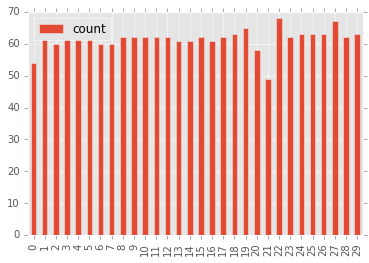

In [4]:
post_count_by_day = \
    sorted(list(collection.aggregate([{'$match': {'page_name': 'Shared'
           , 'date':{'$gte': startdate,'$lte': enddate}}},
           {'$group': {'_id': '$date', 'count': {'$sum': 1}}}])),
           key=lambda k: k['_id'])
post_count_by_day_df = json_normalize(post_count_by_day)
post_count_by_day_df[['_id','count']].plot.bar()
print 'min: ',np.min(post_count_by_day_df['count'])
print 'max: ',np.max(post_count_by_day_df['count'])
print 'avg: ',np.average(post_count_by_day_df['count'])

In [5]:
reducer = \
    Code("""
    function(obj, prev) {
        if (true != null) if (true instanceof Array) prev.countstar += true.length;
        else prev.countstar++;
        prev.sumpost_likes = prev.sumpost_likes + obj.post_likes - 0;
        prev.sumpost_comments = prev.sumpost_comments + obj.post_comments - 0;
        prev.sumpost_shares = prev.sumpost_shares + obj.post_shares - 0;
        prev.sumpost_reactions_total = prev.sumpost_reactions_total + obj.post_reactions_total - 0;
        prev.sumpost_impressions_unique = prev.sumpost_impressions_unique + obj.post_impressions_unique - 0;
        prev.sumpost_impressions = prev.sumpost_impressions + obj.post_impressions - 0;
        prev.sumpost_impressions_fan = prev.sumpost_impressions_fan + obj.post_impressions_fan - 0;
        prev.sumpost_impressions_fan_unique = prev.sumpost_impressions_fan_unique + obj.post_impressions_fan_unique - 0;
        prev.sumpost_link_clicks = prev.sumpost_link_clicks + obj.post_link_clicks - 0;
        prev.sumpost_link_clicks_unique = prev.sumpost_link_clicks_unique + obj.post_link_clicks_unique - 0;
        prev.sumpost_engaged_users = prev.sumpost_engaged_users + obj.post_engaged_users - 0;
    }
    """)

post_summary_sum = db.post_summary.group(key=None,initial={
    'countstar': 0,
    'sumpost_engaged_users': 0,
    'sumpost_reactions_total': 0,
    'sumpost_link_clicks': 0,
    'sumpost_impressions_unique': 0,
    'sumpost_likes': 0,
    'sumpost_comments': 0,
    'sumpost_shares': 0,
    'sumpost_impressions': 0,
    'sumpost_impressions_fan': 0,
    'sumpost_impressions_fan_unique': 0,
    'sumpost_link_clicks_unique': 0,
    }, reduce=reducer, condition={'page_name': 'Shared',
                                  'date': {'$gt': startdate,
                                  '$lt': enddate}}, finalize=None)

# http://stackoverflow.com/questions/29039298/how-to-write-mongodb-query-in-python-for-db-collection-group
# http://api.mongodb.com/python/current/examples/aggregation.html


post_summary_avg = pd.DataFrame(post_summary_sum).transpose()
postcount = post_summary_avg[0]['countstar']
post_summary_avg['avg'] = post_summary_avg / postcount
post_summary_avg

,0,avg
countstar,1850.000,1.000
sumpost_comments,3322883.000,1796.153
sumpost_engaged_users,127681924.000,69017.256
sumpost_impressions,2850367980.000,1540739.449
sumpost_impressions_fan,1608921981.000,869687.557
sumpost_impressions_fan_unique,1060654746.000,573326.890
sumpost_impressions_unique,1796794901.000,971240.487
sumpost_likes,24990113.000,13508.169
sumpost_link_clicks,72895189.000,39402.805
sumpost_link_clicks_unique,68539073.000,37048.148


In [35]:
pagesize = db.page_month_summary.find_one({'page_name':'Shared','year':2017,'month':'May'})['page_fans']
print "pagesize:",pagesize

impression_unique_ratio = post_summary_avg['avg']['sumpost_impressions']/post_summary_avg['avg']['sumpost_impressions_unique']
print "impression unique ratio:",impression_unique_ratio

pagesize: 11664651
impression unique ratio: 1.58636246041


There are about 1 million (sumpost_impressions_unique) unique people who account for the 1.5 million impressions (sumpost_impressions), on average, they made about 1.58 impressions for each posts.

Out of the 1 million people, 60% of them are our page fan (sumpost_impressions_fan_unique). That is about 5% of our page size (sumpost_impressions_fan_unique/ pagesize), however we don't know if the 5% are overlapped for each post, we will assume that they are randomly selected. We can model it using binomial distribution where p=0.05, we have about 1850 posts a month. The probabilty distribution:

reach size ratio fan: 0.0491507966873
5% percentile:  76.0


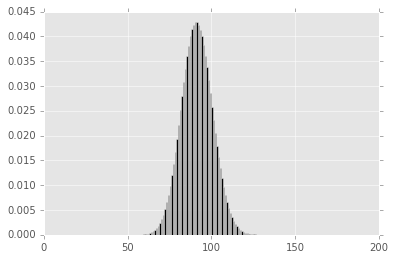

In [36]:
reachsizeratiofan = post_summary_avg['avg']['sumpost_impressions_fan_unique']/pagesize
print "reach size ratio fan:",reachsizeratiofan

x = range(200)
y = stats.binom.pmf(x,postcount,reachsizeratiofan)
plt.bar(x,y, color="black")

print "5% percentile: ",stats.binom.ppf(0.05, postcount, reachsizeratiofan, loc=0)

**On average, they should see about 90 posts on average per month (about 142 impressions).** 95% of them will see at least 76 posts (~120 impressions).

Next we need P(link click | impression), given an impression, what is the probabilty that one will click on the link? Using the avg_link_clicks_to_impressions, there are around 3% chance they click on a link given an impression. Lets say on average they see about 142 impressions, **they make about 3.63 clicks on any of our posts each month.**


In [37]:
avg_link_clicks_unique_to_impressions_unique = post_summary_avg[0]['sumpost_link_clicks_unique']/ post_summary_avg[0]['sumpost_impressions_unique']
# ad-hoc link_clicks_unique_impressions_unique ratio, it is not available on Mongo

avg_link_clicks_to_impressions = post_summary_avg[0]['sumpost_link_clicks']/ post_summary_avg[0]['sumpost_impressions']

# ad-hoc link_clicks_impressions ratio, it is not available on Mongo

print 'avg_link_clicks_unique_to_impressions_unique: ',avg_link_clicks_unique_to_impressions_unique
print 'avg_link_clicks_to_impressions: ' ,avg_link_clicks_to_impressions

avg_link_clicks_unique_to_impressions_unique:  0.0381451844959
avg_link_clicks_to_impressions:  0.0255739572966


However, not all of the clicks generate revenue, only link clicks lead to our website or our partner's website that generate ad revenue. To estimate the revenue brought by each click/ each facebook fan, we should do further breakdown on post type.

### Breakdown by post type

In [38]:
post_type_count = \
    list(collection.aggregate([{'$match': {'page_name': 'Shared',
         'date': {'$gte': startdate, '$lte': enddate}}},
         {'$group': {'_id':'$post_type', 'count': {'$sum': 1}}}]))
post_type_count_df = json_normalize(post_type_count).sort_values('_id')
post_type_count_df

,_id,count
2,link,1347
1,photo,76
0,video,427


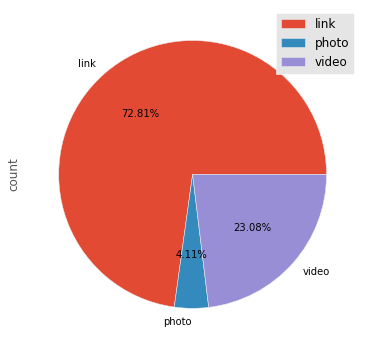

In [39]:
post_type_count_df.plot.pie('count',labels=post_type_count_df['_id'],figsize=(6, 6),autopct='%.2f%%')

73% of them are link posts, 23% are video posts, only less than 4% are photo posts. Doing a similar aggreagating, breakdown by post type:

In [40]:
reducer = \
    Code("""
    function(obj, prev) {
        if (true != null) if (true instanceof Array) prev.countstar += true.length;
        else prev.countstar++;
        prev.sumpost_likes = prev.sumpost_likes + obj.post_likes - 0;
        prev.sumpost_comments = prev.sumpost_comments + obj.post_comments - 0;
        prev.sumpost_shares = prev.sumpost_shares + obj.post_shares - 0;
        prev.sumpost_reactions_total = prev.sumpost_reactions_total + obj.post_reactions_total - 0;
        prev.sumpost_impressions_unique = prev.sumpost_impressions_unique + obj.post_impressions_unique - 0;
        prev.sumpost_impressions = prev.sumpost_impressions + obj.post_impressions - 0;
        prev.sumpost_impressions_fan = prev.sumpost_impressions_fan + obj.post_impressions_fan - 0;
        prev.sumpost_impressions_fan_unique = prev.sumpost_impressions_fan_unique + obj.post_impressions_fan_unique - 0;
        prev.sumpost_link_clicks = prev.sumpost_link_clicks + obj.post_link_clicks - 0;
        prev.sumpost_link_clicks_unique = prev.sumpost_link_clicks_unique + obj.post_link_clicks_unique - 0;
        prev.sumpost_engaged_users = prev.sumpost_engaged_users + obj.post_engaged_users - 0;
    }
    """)

post_summary_sum_by_post_type = db.post_summary.group(key={'post_type': True},initial={
    'countstar': 0,
    'sumpost_engaged_users': 0,
    'sumpost_reactions_total': 0,
    'sumpost_link_clicks': 0,
    'sumpost_impressions_unique': 0,
    'sumpost_likes': 0,
    'sumpost_comments': 0,
    'sumpost_shares': 0,
    'sumpost_impressions': 0,
    'sumpost_impressions_fan': 0,
    'sumpost_impressions_fan_unique': 0,
    'sumpost_link_clicks_unique': 0,
    }, reduce=reducer, condition={'page_name': 'Shared',
                                  'date': {'$gt': startdate,
                                  '$lt': enddate}}, finalize=None)

post_summary_sum_by_post_type;

In [41]:
post_summary_sum_by_post_type_df = pd.DataFrame(post_summary_sum_by_post_type).transpose()
post_summary_sum_by_post_type_df['avg_link'] = \
pd.to_numeric(post_summary_sum_by_post_type_df[0],errors='coerce')/ post_summary_sum_by_post_type_df[0]['countstar']
post_summary_sum_by_post_type_df['avg_photo'] = \
pd.to_numeric(post_summary_sum_by_post_type_df[1],errors='coerce')/ post_summary_sum_by_post_type_df[1]['countstar']
post_summary_sum_by_post_type_df['avg_video'] = \
pd.to_numeric(post_summary_sum_by_post_type_df[2],errors='coerce')/ post_summary_sum_by_post_type_df[2]['countstar']

def highlight_max(s):
    '''
    highlight the maximum in a Series yellow.
    '''
    is_max = s == s.max()
    return ['background-color: yellow' if v else '' for v in is_max]

post_summary_sum_by_post_type_df.style.apply(highlight_max, subset=['avg_link', 'avg_photo', 'avg_video'],axis=1)

We can see the average engagement stat of a link/photo/video post from the table above, observation:
1. Facebook users are highly engaged with video posts compared with link posts. In terms of comments/ reactions/ shares, it is over **20x more than link post**.
2. Photo posts also perform better than link post. In terms of comments/ reactions/ shares, it is about **3x more than link posts**.
3. 98.7% of the link clicks are from link posts. Since some of the photo/ video posts do not have any link, the avg link clicks are lower which is expected.

Since we generate revenue mostly on link clicks, our goal is to increase link clicks on each posts. Based on the huge difference in engagement in video/ photo posts, it is suggested to always include a relevant link in all of our posts or try to increase the click rate on the posts already with links. 

---


### Our revenue source: link posts

Most of our revenue are from link clicks, we are going to focus a similar analysis filtered to link posts only.

There are about 600k (sumpost_impressions_unique) unique people who account for the 900k impressions (sumpost_impressions), on average, they made about 1.5 impressions for each posts.

Out of the 900k people, 78% of them are our page fan (sumpost_impressions_fan_unique). That is about 4% of our page size (sumpost_impressions_fan_unique/ pagesize), however we don't know if the 4% are overlapped for each post, we will assume that they are randomly selected. We can model it using binomial distribution where p=0.04, we have about 1347 link posts a month. The probabilty distribution:

reach size ratio fan of link post: 0.0406356045085
5% percentile:  43.0
avg_link_clicks_unique_to_impressions_unique_linkpost:  0.0831375165839
avg_link_clicks_to_impressions_linkpost:  0.0588765912823


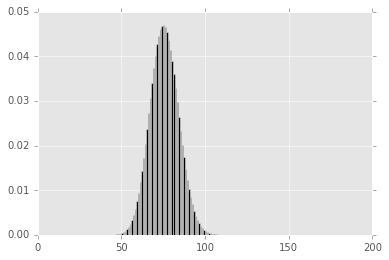

In [42]:
reachsizeratiofan_linkpost = post_summary_sum_by_post_type_df['avg_link']['sumpost_impressions_fan_unique']/pagesize
print "reach size ratio fan of link post:",reachsizeratiofan_linkpost

postcount_linkpost=post_summary_sum_by_post_type_df[0]['countstar']

x = range(200)
y = stats.binom.pmf(x,postcount,reachsizeratiofan_linkpost)
plt.bar(x,y, color="black")

print "5% percentile: ",stats.binom.ppf(0.05, postcount_linkpost, reachsizeratiofan_linkpost, loc=0)

avg_link_clicks_unique_to_impressions_unique_linkpost = post_summary_sum_by_post_type_df[0]['sumpost_link_clicks_unique']/ post_summary_sum_by_post_type_df[0]['sumpost_impressions_unique']
# ad-hoc link_clicks_unique_impressions_unique ratio, it is not available on Mongo

avg_link_clicks_to_impressions_linkpost = post_summary_sum_by_post_type_df[0]['sumpost_link_clicks']/ post_summary_sum_by_post_type_df[0]['sumpost_impressions']

# ad-hoc link_clicks_impressions ratio, it is not available on Mongo

print 'avg_link_clicks_unique_to_impressions_unique_linkpost: ',avg_link_clicks_unique_to_impressions_unique_linkpost
print 'avg_link_clicks_to_impressions_linkpost: ' ,avg_link_clicks_to_impressions_linkpost

**On average, they should see about 53 posts on average per month (about 80 impressions).** 95% of them will see at least 43 posts (~64 impressions).

Next we need P(link click | impression), given an impression, what is the probabilty that one will click on the link? Using the avg_link_clicks_to_impressions, there are around 6% chance they click on a link given an impression. Lets say on average they see about 80 impressions, **they make about 4.7 clicks on any of our link posts each month.**


There are 2 types of link posts: 1. Shared.com link post 2. Partner's link post. For our own article posts, we generate revenue by ad impressions on the page through ad partners/ MM. For partner's link post, we drive traffic to their site and they will share a split of revenue to us. 

### LTCV

To estimate the lifetime customer value, the standard formula is:
Customer lifetime value (\$) = Margin (\$) * (Retention Rate (%) ÷ ([1 + Discount Rate (%)] - Retention Rate (%))


there are 2 things we need to find:
1. How many times a customer visit our site?
2. How much \$ we make on each visit?

From the analysis on link click, we estimate that a facebook fan would make about 4.7 clicks to our link posts. We assume each click initiates a session on our website (or on our partner's site)

Total revenue in May: \$185441.81

Total site sessions: 24353113

Total pageviews: 37509650

RPS: \$7.71

In [49]:
post_summary_sum_sharedlinkpost = db.post_summary.group(key=None,initial={
    'countstar': 0,
    'sumpost_engaged_users': 0,
    'sumpost_reactions_total': 0,
    'sumpost_link_clicks': 0,
    'sumpost_impressions_unique': 0,
    'sumpost_likes': 0,
    'sumpost_comments': 0,
    'sumpost_shares': 0,
    'sumpost_impressions': 0,
    'sumpost_impressions_fan': 0,
    'sumpost_impressions_fan_unique': 0,
    'sumpost_link_clicks_unique': 0,
    }, reduce=reducer, condition={'page_name': 'Shared',
                                  'date': {'$gt': startdate,
                                  '$lt': enddate},
                                  'post_type':'link',
                                  'post_domain':'shared.com'}, finalize=None)


In [55]:
post_summary_avg_sharedlinkpost = pd.DataFrame(post_summary_sum_sharedlinkpost).transpose()
postcount_sharedlinkpost = post_summary_avg_sharedlinkpost[0]['countstar']
post_summary_avg_sharedlinkpost['avg'] = post_summary_avg_sharedlinkpost / postcount_sharedlinkpost
post_summary_avg_sharedlinkpost['avg_link']=post_summary_sum_by_post_type_df['avg_link']
post_summary_avg_sharedlinkpost

,0,avg,avg_link
countstar,138.000,1.000,1.000
sumpost_comments,43051.000,311.964,308.742
sumpost_engaged_users,6635894.000,48086.188,59202.889
sumpost_impressions,105395576.000,763736.058,907124.403
sumpost_impressions_fan,69867283.000,506284.659,702602.313
sumpost_impressions_fan_unique,46561201.000,337400.007,474000.145
sumpost_impressions_unique,68076465.000,493307.717,604224.350
sumpost_likes,110735.000,802.428,1645.616
sumpost_link_clicks,6105657.000,44243.891,53408.393
sumpost_link_clicks_unique,5841324.000,42328.435,50233.712


Only 138 link posts from Shared.com, which is about 10% of our link posts. Comparing with the overall link posts performance, we can see partner's link post perform slight better in term of impressions/ link clicks. And they get almost twice as many reactions and shares.

In [53]:
post_summary_sum_by_post_type_df['avg_link']

countstar                             1.000
post_type                               nan
sumpost_comments                    308.742
sumpost_engaged_users             59202.889
sumpost_impressions              907124.403
sumpost_impressions_fan          702602.313
sumpost_impressions_fan_unique   474000.145
sumpost_impressions_unique       604224.350
sumpost_likes                      1645.616
sumpost_link_clicks               53408.393
sumpost_link_clicks_unique        50233.712
sumpost_reactions_total            2263.728
sumpost_shares                      796.817
Name: avg_link, dtype: float64

### Breakdown by partner

In [37]:
post_by_brand = [
    {
        "brand_domain" : "Shareably",
        "countstar" : 69.0
    },
    {
        "brand_domain" : "not defined",
        "countstar" : 376.0
    },
    {
        "brand_domain" : "Rndr",
        "countstar" : 160.0
    },
    {
        "brand_domain" : "Little Things",
        "countstar" : 187.0
    },
    {
        "brand_domain" : "Trancos",
        "countstar" : 65.0
    },
    {
        "brand_domain" : "Random Stuff",
        "countstar" : 228.0
    },
    {
        "brand_domain" : "Inspire More",
        "countstar" : 41.0
    },
    {
        "brand_domain" : "HeroViral",
        "countstar" : 92.0
    },
    {
        "brand_domain" : "PawMyGosh",
        "countstar" : 12.0
    },
    {
        "brand_domain" : "BoredomTherapy",
        "countstar" : 29.0
    },
    {
        "brand_domain" : "American Overlook",
        "countstar" : 123.0
    },
    {
        "brand_domain" : "Bricor Media",
        "countstar" : 5.0
    },
    {
        "brand_domain" : "GoFansGo",
        "countstar" : 3.0
    },
    {
        "brand_domain" : "Tickld",
        "countstar" : 1.0
    },
    {
        "brand_domain" : "Unsure Clients",
        "countstar" : 1.0
    },
    {
        "brand_domain" : "SF Globe",
        "countstar" : 4.0
    },
    {
        "brand_domain" : "TwentyTwoWords",
        "countstar" : 1.0
    }
]

In [38]:
post_by_brand_df = pd.DataFrame(post_by_brand).sort_values('countstar',ascending=False)
post_by_brand_df 

,brand_domain,countstar
1,not defined,376.000
5,Random Stuff,228.000
3,Little Things,187.000
2,Rndr,160.000
10,American Overlook,123.000
7,HeroViral,92.000
0,Shareably,69.000
4,Trancos,65.000
6,Inspire More,41.000
9,BoredomTherapy,29.000
